In [1]:
%matplotlib inline
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skbio import DistanceMatrix


probe_alignment_dir = "alignments_for_probe_design"
pdistance_dir = "onekp_only_angios_pdistance"


Images to make:

* Comparison of pairwise distances using manual reference sequences vs. k-medoids method.
* Heatmap of gene recovery (HybPiper style)
* Genes recovered vs. reads mapped, colored by category
* Stackplot showing total sequence recovered at 8x depth vs coding sequence only. (Maybe redundant with heatmap).

Other images:
* Breakdown of gene recovery-- any reads vs contigs vs sequences vs 50%



# Figure 1: Comparison of the k-medoids method with manual selection of reference sequences (using only published genomes). 

In the other notebook I used just one gene, but would it be possible to include data from all genes? Scatterplot of percentage of angiosperm sequences with > 25% sequence divergence in k-mediods vs manual. Would need to run a calculation of the distances using the manual medoids. 

* Read in k-medoid list
* For each gene, read in distance matrix and calculate for every individual:
    * Distance to nearest k-medoid
    * Distance to nearest genome
* Create a table with genes as rows and the percentage of individuals > 30% divergent for each gene.
* Plot as scatter plot

In [4]:
manual_centroids = ["Arath_TAIR10","Ambtr_v1.0.27","Orysa_v7.0","Vitvi_Genoscope.12X","Mimgu_v2.0","Poptr_v3.0"]

medoid_dict = {}
for gene in open("../medoids_final.txt"):
    gene = gene.rstrip().split()
    gene_name = gene[0]
    medoids = gene[8:]
    medoid_dict[gene_name] = medoids
        
distance_threshold = 0.3
num_distant_seqs = []
for gene in medoid_dict:
    dm = DistanceMatrix.read(os.path.join(pdistance_dir,"{}_angio_P_dm.csv".format(gene)))
    dm_df = dm.to_data_frame()
    gene_manual_centroids = [x for x in manual_centroids if x in dm_df.columns]
    manual_dist = dm_df[gene_manual_centroids].apply(min,1)
    kmedoid_dist = dm_df[medoid_dict[gene]].apply(min,1)
    manual_overthresh = len(manual_dist[manual_dist  <= distance_threshold])/len(manual_dist)
    kmedoid_overthresh = len(kmedoid_dist[kmedoid_dist <= distance_threshold])/len(kmedoid_dist)
    num_distant_seqs.append((gene,manual_overthresh,kmedoid_overthresh))
num_distant_seqs = pd.DataFrame(num_distant_seqs,columns=("Gene","Manual","KMedoid"))
num_distant_seqs=num_distant_seqs.set_index("Gene")

In [5]:
print('''Using manual medoids, the number of genes that can represent 95% of angiosperms is {}.\nUsing k-medoids, the number of genes that can represent 95% of angiosperms is {}'''.format(
    len(num_distant_seqs[num_distant_seqs.Manual >= 0.95]),
    len(num_distant_seqs[num_distant_seqs.KMedoid >= 0.95])))

Using manual medoids, the number of genes that can represent 95% of angiosperms is 219.
Using k-medoids, the number of genes that can represent 95% of angiosperms is 352


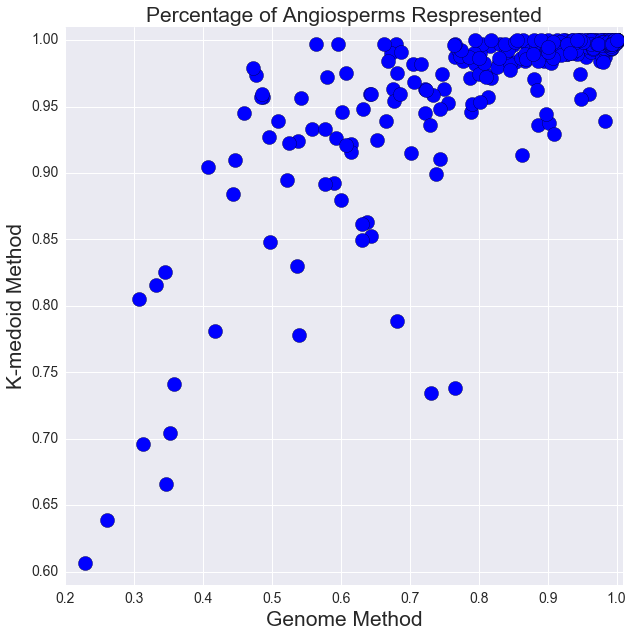

In [6]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
plt.xlabel("Genome Method",fontsize=21)
plt.ylabel("K-medoid Method",fontsize=21)
plt.title("Percentage of Angiosperms Respresented",fontsize=21)
plt.xlim([0.2,1.01])
plt.ylim([0.59,1.01])
plt.xticks(fontsize=14)
plt.yticks([x/100 for x in range(60,105,5)],fontsize=14)
ax1.scatter(x=num_distant_seqs.Manual, y=num_distant_seqs.KMedoid, marker='o', c='b', edgecolor='black',s=200)

In [25]:
num_distant_seqs.loc["5348"]

Manual     0.472917
KMedoid    0.979167
Name: 5348, dtype: float64

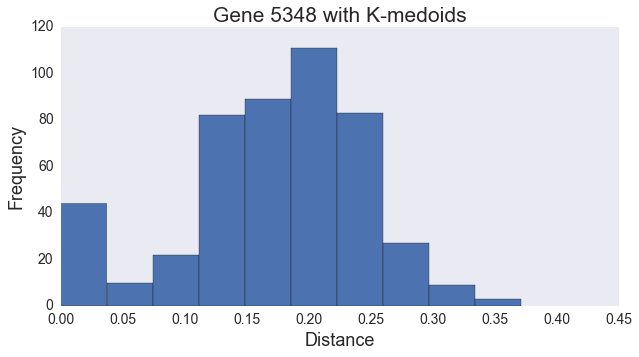

In [23]:
fig1b, ax1b = plt.subplots(figsize=(10, 5))

example_gene = "5348"
dm = DistanceMatrix.read(os.path.join(pdistance_dir,"{}_angio_P_dm.csv".format(example_gene)))
dm_df = dm.to_data_frame()
gene_manual_centroids = [x for x in manual_centroids if x in dm_df.columns]
manual_dist = dm_df[gene_manual_centroids].apply(min,1)

kmedoid_dist = dm_df[medoid_dict[example_gene]].apply(min,1)

n, bins, patches = plt.hist(kmedoid_dist)#, 50, normed=1, facecolor='green', alpha=0.75)


plt.xlabel('Distance',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title(r'Gene 5348 with K-medoids',fontsize=21)
plt.xticks(fontsize=14)
plt.xlim([0,0.45])
plt.yticks(fontsize=14)
plt.grid(False)

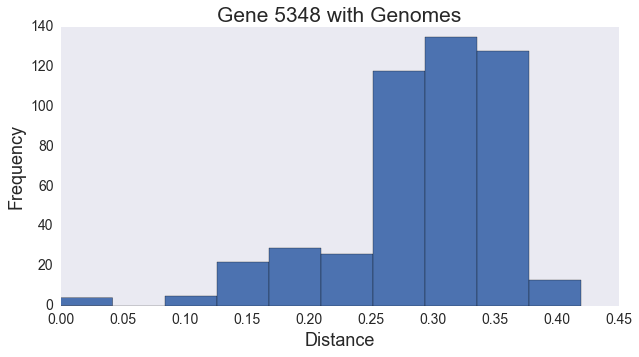

In [20]:
fig1c, ax1c = plt.subplots(figsize=(10, 5))
n, bins, patches = plt.hist(manual_dist)#, 50, normed=1, facecolor='green', alpha=0.75)


plt.xlabel('Distance',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.title(r'Gene 5348 with Genomes',fontsize=21)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.axis([40, 160, 0, 0.03])
plt.grid(False)

# Figure 2. HybPiper style heatmap, with rows ordered according to category.


* Read in the gene_lengths.txt output from HybPiper.
* Convert lengths to percentages, capped at 1.0
* Read in the full summary table, which includes the category.
* Reorder rows based on category.
* Borrow heatmap plot from alleles paper. 




In [6]:

gene_lengths = pd.read_csv("final_seqlengths.txt",sep="\t",header=0,index_col=0)
mean_lengths=gene_lengths.loc["MeanLength"]
gene_lengths = gene_lengths.drop("MeanLength")
percent_len = gene_lengths.div(mean_lengths,axis="columns")
percent_len[percent_len > 1 ] = 1


In [51]:
recovery_stats = pd.read_csv("final_recovery_summary.txt",sep="\t",header=0,index_col=0)
recovery_stats =recovery_stats.sort_values(["Category","genusName"])
percent_len = percent_len.reindex(recovery_stats.index)
categories = recovery_stats.Category.value_counts().sort_index()


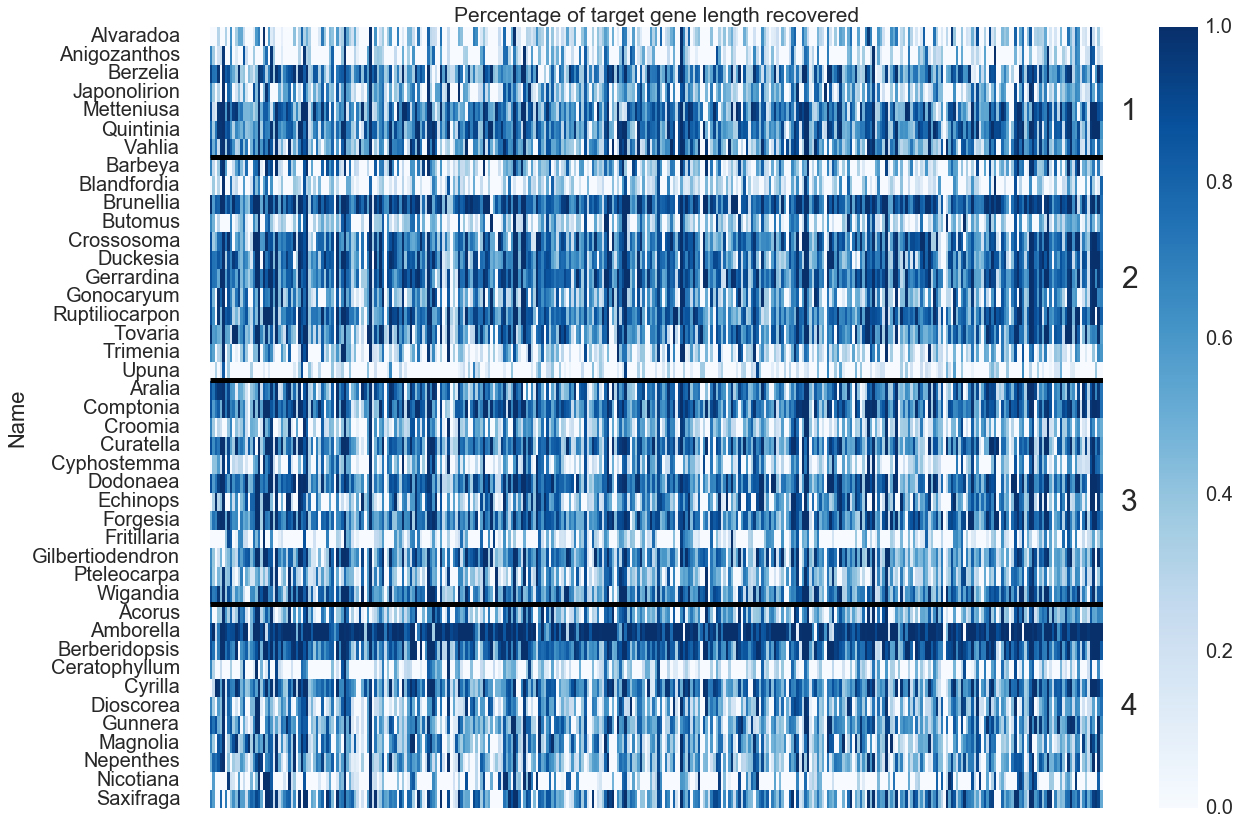

In [77]:
fig2, ax2 = plt.subplots(figsize=(20, 14))
plt.title("Percentage of target gene length recovered",fontsize=21)
ax2 = sns.heatmap(percent_len,xticklabels=False,yticklabels=list(recovery_stats.genusName),cmap="Blues")#,mask=np.isnan(percent_len),vmin=-1,vmax=2,linewidths=0.5,linecolor='black')
#sns.heatmap(allele_report,xticklabels=False,cmap="RdBu",mask=allele_report > 1,vmin=-1,vmax=1,linewidths=0.5,linecolor='black')
ax2.tick_params(axis='y', which='major', pad=30)

ax2.text(360,5,"4",fontsize=30, rotation=0)
ax2.text(360,16,"3",fontsize=30, rotation=0)
ax2.text(360,28,"2",fontsize=30, rotation=0)
ax2.text(360,37,"1",fontsize=30, rotation=0)
ax2.hlines([11, 23, 35], *ax2.get_xlim(),linewidth=5,color='black')

# Figure 3. Scatterplot of Reads Mapped vs Sequence recovered, colored by category.

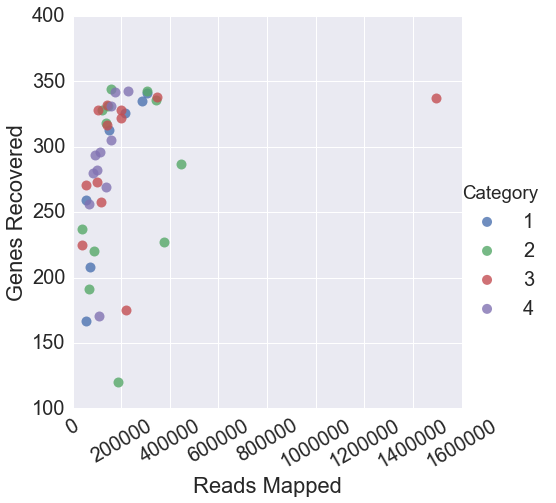

In [53]:
#fig, ax = plt.subplots(figsize=(10, 10))
#plt.xlabel("Reads Mapped",fontsize=21)
#plt.ylabel("Genes Recovered",fontsize=21)
#plt.title("Percentage of Angiosperms Respresented",fontsize=21)
#plt.ylim([-1,355])
#plt.xlim([-1,1600000])
#plt.yticks(fontsize=14)
sns.set(font_scale=2)

fig3 = sns.lmplot(x="ReadsMapped",y="GenesWithSeqs",data=recovery_stats,hue="Category",
               fit_reg=False,legend=True,size=7,scatter_kws={"s": 100})

fig3.set(xlim=(-1,1600000))
fig3.set_axis_labels("Reads Mapped","Genes Recovered")
fig3.set_xticklabels(rotation=30)
#plt.vlines(x=100000,ymin=0,ymax=350)

# Figure 4. Stackplot showing the recovery of reads, contigs, genes, and genes above 50% for each taxon. 

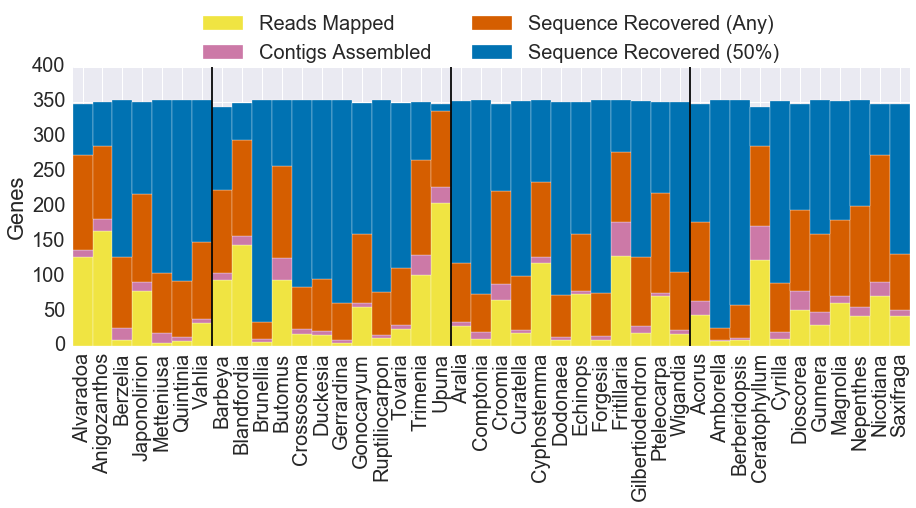

In [79]:
fig4, ax4 = plt.subplots(figsize=(15, 5))
stacked_bar_df = pd.DataFrame(index=recovery_stats.index)
stacked_bar_df["bar1"] = recovery_stats.GenesMapped - recovery_stats.GenesWithContigs
stacked_bar_df["bar2"] = recovery_stats.GenesWithContigs - recovery_stats.GenesWithSeqs
stacked_bar_df["bar3"] = recovery_stats.GenesWithSeqs - recovery_stats.GenesAt50pct
stacked_bar_df["bar4"] = recovery_stats.GenesAt50pct

stacked_bar_df["bars12"] = stacked_bar_df.bar1 + stacked_bar_df.bar2
stacked_bar_df["bars123"] = stacked_bar_df.bar1 + stacked_bar_df.bar2 + stacked_bar_df.bar3

barWidth=1
r=list(range(len(stacked_bar_df)))
plt.bar(r, stacked_bar_df.bar1, color='#f0e442', edgecolor='white', width=barWidth)
plt.bar(r, stacked_bar_df.bar2, bottom=stacked_bar_df.bar1, color='#cc79a7', edgecolor='white', width=barWidth)
plt.bar(r, stacked_bar_df.bar3, bottom=stacked_bar_df.bars12, color='#d55e00', edgecolor='white', width=barWidth)
plt.bar(r, stacked_bar_df.bar4, bottom=stacked_bar_df.bars123, color='#0072b2', edgecolor='white', width=barWidth)
plt.xlim([0,42])
plt.ylabel("Genes")
i=plt.xticks([0.5+i for i in r],list(recovery_stats.genusName),rotation=90)
plt.legend(["Reads Mapped","Contigs Assembled","Sequence Recovered (Any)","Sequence Recovered (50%)"],
          loc="upper center",
          bbox_to_anchor=(0.5, 1.25),
          ncol=2)
ax4.vlines([7,19,31],*ax4.get_ylim())


# Figure 5. Sequence recovery at at least 8x coverage depth in coding sequences and introns.






In [55]:
depth_df = pd.read_csv("depth_summary.txt",sep="\t",index_col=0,header=None,names=["Exons","Supercontigs"])
recovery_stats = pd.concat((depth_df,recovery_stats),axis=1)


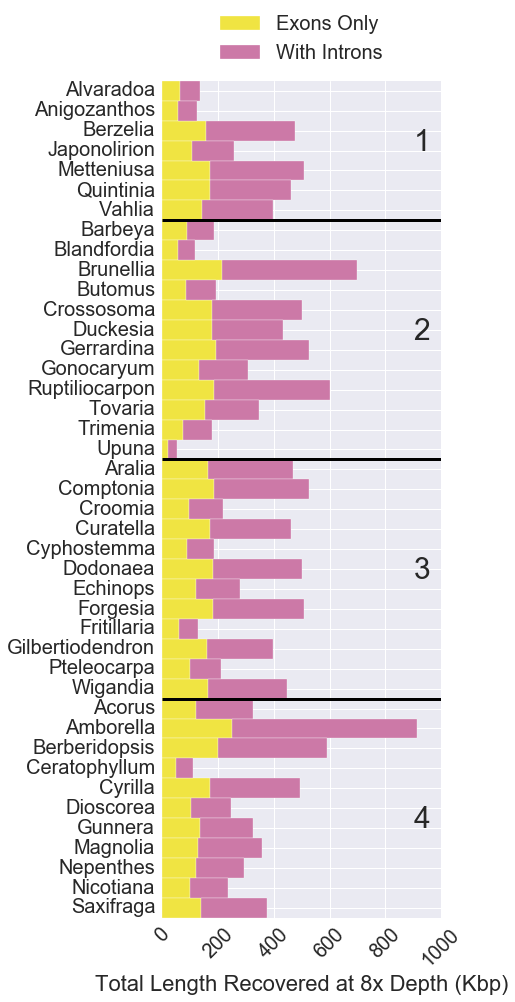

In [73]:
recovery_stats =recovery_stats.sort_values(["Category","genusName"])

fig5, ax5 = plt.subplots(figsize=(5, 15))

barWidth=1
r=list(range(len(recovery_stats)))
plt.barh(r, recovery_stats.Exons, color='#f0e442', edgecolor='white', height=barWidth, )
plt.barh(r, recovery_stats.Supercontigs - recovery_stats.Exons,  left=recovery_stats.Exons, color='#cc79a7', edgecolor='white', height=barWidth)
plt.ylim([0,42])
plt.xlabel("Total Length Recovered at 8x Depth (Kbp)")
yticks5=plt.yticks([0.5+i for i in r],list(recovery_stats.genusName))
plt.legend(["Exons Only","With Introns"],
          loc="upper center",
          bbox_to_anchor=(0.5, 1.1),
          ncol=1)
xticks5=plt.xticks([0,200000,400000,600000,800000,1000000],[0,200,400,600,800,1000],rotation=45)
ax5.hlines([7, 19, 31], *ax5.get_xlim(),linewidth=3,color='black')
ax5.text(900000,3.5,"1",fontsize=30, rotation=0)
ax5.text(900000,13,"2",fontsize=30, rotation=0)
ax5.text(900000,25,"3",fontsize=30, rotation=0)
ax5.text(900000,37.5,"4",fontsize=30, rotation=0)
ax5.invert_yaxis()

In [96]:
import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
introns=recovery_stats.Supercontigs - recovery_stats.Exons
introns = pd.concat([introns,recovery_stats.Category],axis=1)
introns.columns = ["IntronLength","Category"]
mylm = ols("IntronLength ~ C(Category)",data=introns).fit()
table = sm.stats.anova_lm(mylm,typ=2)
table

,sum_sq,df,F,PR(>F)
C(Category),9.286098e+09,3.0,0.168782,0.91679
Residual,6.968985e+11,38.0,NaN,NaN


In [27]:
fig1.savefig("kmedoidsVSgenomes_scatter.pdf")
fig1b.savefig("gene5348_kmedoids.pdf")
fig1c.savefig("gene5348_genomes.pdf")
fig2.savefig("Figure2_RecoveryHeatmap.png")
fig3.savefig("Figure3_readsMappedVSgeneRecovery.png")
fig4.savefig("Figure4_RecoveryStatus.png")
fig5.savefig("Figure5_depth8x.png")


NameError: name 'fig2' is not defined

In [97]:
recovery_stats.Exons.median()

137046.0